# Project Summary

## Business Objective

## Data Options

## Executive Summary

# Data Load & Prep


## Import Libraries


In [49]:
# Import libraries required to load, transform, analyze and plot data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set display option to remove scientific notation and restrictions on df rows/columns display
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

# Invoke magic command to load memroy profiler to monitor dataframe memory usage
import sys  # system specific parameters and names
import gc   # garbage collector interface: use gc.collect() after deleting df's

In [2]:
# Add jupytertheme to this notebook
!jt -t onedork -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T # To add back toolfar: jt -t grade3 -T -N

## Memory Usage Function

In [50]:
# Functions to check object size and memory usage to use in tandem with gc
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")

def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

## Load Source Dataframes

The "Load Source" section includes commands required to load source data files, modify certain columns and data types as well as handle null values. This section creates the baseline dataframes that are used in section 3 feature engineering.

### Load IMBD Basics

In [51]:
# Load IMDB Basics file as movie title master (primary driver dataframe)
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')

# Convert minutes from float to integer to correct data type for display later on
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')

# Validate data types, record counts and check memory usage
imdb_basics.info()
imdb_basics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           146144 non-null  object
 1   primary_title    146144 non-null  object
 2   original_title   146123 non-null  object
 3   start_year       146144 non-null  int64 
 4   runtime_minutes  114405 non-null  Int64 
 5   genres           140736 non-null  object
dtypes: Int64(1), int64(1), object(4)
memory usage: 6.8+ MB


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80,"Comedy,Drama,Fantasy"


### Load IMDB Ratings

In [52]:
# Load IMDB Ratings file, will be merged with IMBD Basics; standarized column names
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)

# Convert votes from float to integer to correct data type for display later on
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')

# Validate data types, record counts and preview records
imdb_ratings.info()
imdb_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      73856 non-null  object 
 1   avg_rating  73856 non-null  float64
 2   num_votes   73856 non-null  Int64  
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.8+ MB


,tconst,avg_rating,num_votes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


### Load BOM Movie Gross

In [53]:
# Load BOM Movie Gross file, will be merged with IMBD Basics
bom = pd.read_csv('data/bom.movie_gross.csv')
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,"415,000,000.00",652000000,2010
1,Alice in Wonderland (2010),BV,"334,200,000.00",691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,"296,000,000.00",664300000,2010
3,Inception,WB,"292,600,000.00",535700000,2010
4,Shrek Forever After,P/DW,"238,700,000.00",513900000,2010


In [54]:
# Remove quotes and nulls to convert from object to integer data type 
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')

# Remove commas and nulls to convert from object to integer data type 
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')

In [55]:
# Validate bom data types, record counts and preview records
bom.info()
bom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3387 non-null   Int64 
 3   foreign_gross   3387 non-null   Int64 
 4   year            3387 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 139.0+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000,652000000,2010
1,Alice in Wonderland (2010),BV,334200000,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000,664300000,2010
3,Inception,WB,292600000,535700000,2010
4,Shrek Forever After,P/DW,238700000,513900000,2010


### Load TN Movie Budgets

In [56]:
# Load TN Movie Budget file, will be merged with IMBD Basics
tn = pd.read_csv('data/tn.movie_budgets.csv')

# Validate tn data types, record counts and preview records
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [57]:
# Remove non-ascii characters from movie series (prevents matching to IMDB Basics)
tn['movie'] = tn['movie'].str.encode('ascii', 'ignore').str.decode('ascii')

# Convert release date series to date format; extract year as new column for matching along with movie
tn['release_date'] = pd.to_datetime(tn['release_date'], infer_datetime_format=True).dt.floor('d')
tn['year'] = tn['release_date'].dt.year

# Strip $ from 3 currency columns and format as float
currency_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']
tn[currency_cols] = tn[currency_cols].apply(lambda x: x.str.replace('$', '').str.replace(',', ''))
tn[currency_cols] = tn[currency_cols].astype('float')

# Validate tn data types, record counts and preview records
tn.info()
tn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
 6   year               5782 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 316.3+ KB


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00",2009
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"410,600,000.00","241,063,875.00","1,045,663,875.00",2011
2,3,2019-06-07,Dark Phoenix,"350,000,000.00","42,762,350.00","149,762,350.00",2019
3,4,2015-05-01,Avengers: Age of Ultron,"330,600,000.00","459,005,868.00","1,403,013,963.00",2015
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00",2017


In [58]:
# Identify duplicated movies in tn
dups = tn[tn.duplicated(subset=['movie','year'],keep=False)] 
display(dups.head())

# Combine duplicate row for 2009 'Home' movie - single movie found duplicated
home1 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-04-23')] # more complete record
home2 = tn[(tn['movie'] == 'Home') & (tn['release_date'] == '2009-06-05')] # but contains budget $12m we want
home2_budget = home2['production_budget'].sum() 
home1['production_budget'] = home1['production_budget'] + home2_budget # append extra budget from dup

# Drop dup and update surviving record
tn.drop(home2.index, inplace = True)
tn.update(home1)

#Validate 2019 'Home' has been combined
display(tn[(tn['movie'] == 'Home') ])


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
3455,56,2009-06-05,Home,"12,000,000.00",0.00,0.00,2009
5459,60,2009-04-23,Home,"500,000.00","15,433.00","44,793,168.00",2009


<ipython-input-58-80bfff1901ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home1['production_budget'] = home1['production_budget'] + home2_budget # append extra budget from dup


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
243,44.00,2015-03-27,Home,"130,000,000.00","177,397,510.00","385,997,896.00","2,015.00"
5459,60.00,2009-04-23,Home,"12,500,000.00","15,433.00","44,793,168.00","2,009.00"


### Load IMDB Principals

In [59]:
# Load IMBD Principals for keys and category columns only
prin = pd.read_csv('data/imdb.title.principals.csv', usecols=['tconst','nconst','category'])

# Reduce dataframe size, keep only actor category as focus of analysis (drops producer/director)
prin = prin[prin['category']=='actor']

# Validate prin data types, record counts and preview records
prin.info()
prin.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256718 entries, 0 to 1028181
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tconst    256718 non-null  object
 1   nconst    256718 non-null  object
 2   category  256718 non-null  object
dtypes: object(3)
memory usage: 7.8+ MB


,tconst,nconst,category
0,tt0111414,nm0246005,actor
5,tt0323808,nm2694680,actor
6,tt0323808,nm0574615,actor
14,tt0417610,nm0532721,actor
16,tt0417610,nm0069209,actor


### Load IMBD Name Basics

In [60]:
# Load IMBD Name Basics for key and primary name only; will merge with prin
peop = pd.read_csv('data/imdb.name.basics.csv', usecols=['nconst','primary_name'])
peop.head()

,nconst,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter


In [61]:
# Extend prin dataframe with peop fields; inner join as referential integrity exists
prin = prin.merge(peop, how='inner', left_on='nconst', right_on='nconst', indicator='peop_ind')
prin.head()

,tconst,nconst,category,primary_name,peop_ind
0,tt0111414,nm0246005,actor,Tommy Dysart,both
1,tt0323808,nm2694680,actor,Henry Garrett,both
2,tt0323808,nm0574615,actor,Graham McTavish,both
3,tt1680140,nm0574615,actor,Graham McTavish,both
4,tt7168262,nm0574615,actor,Graham McTavish,both


In [62]:
# Check memory usage of existing dataframes
memory_usage().head()

,Size
peop,81.87MB
prin,68.88MB
movies,52.47MB
imdb_basics,43.49MB
imdb_ratings,5.99MB


In [63]:
# Delete peop dataframe since replicated to prin
del peop
memory_usage().head()

,Size
prin,68.88MB
movies,52.47MB
imdb_basics,43.49MB
imdb_ratings,5.99MB
year_filter,1.27MB


## Data Profiling

The "Data Profiling" section includes various investigations to understand the shape and quality of key series in our dataframes. This section was used to refine the above "Load Source" section as well as develop below "Feature Engineering" section. Running this section is not required to produce section "Business Analysis".

### IMDB Basics Checks

In [64]:
# Review IMDB Basics for nulls and genres data quality check
imdb_basics.info()
display(imdb_basics['genres'].value_counts(sort=True).head(10))
f'genres includes {(len(imdb_basics.genres.value_counts(sort=True)))} unique values'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           146144 non-null  object
 1   primary_title    146144 non-null  object
 2   original_title   146123 non-null  object
 3   start_year       146144 non-null  int64 
 4   runtime_minutes  114405 non-null  Int64 
 5   genres           140736 non-null  object
dtypes: Int64(1), int64(1), object(4)
memory usage: 6.8+ MB


Documentary              32185
Drama                    21486
Comedy                    9177
Horror                    4372
Comedy,Drama              3519
Thriller                  3046
Action                    2219
Biography,Documentary     2115
Drama,Romance             2079
Comedy,Drama,Romance      1558
Name: genres, dtype: int64

'genres includes 1085 unique values'

Notes:
- Nulls include 31K minutes, 5K genre
- Majority single genres but 1085 combinations. Going to have to split genres for analysis.

In [65]:
# Check range of years on IMBD Basics titles
print(imdb_basics['start_year'].value_counts())

2017    17504
2016    17272
2018    16849
2015    16243
2014    15589
2013    14709
2012    13787
2011    12900
2010    11849
2019     8379
2020      937
2021       83
2022       32
2023        5
2024        2
2027        1
2026        1
2025        1
2115        1
Name: start_year, dtype: int64


Notes:
- Year range primarily spans 2010 - 2018 while 2019 apperas partial. Some future date years will be excluded during analysis.

In [66]:
# Check IMBD Basics for dups
tconst_dups = imdb_basics.duplicated(['tconst'],keep=False).sum()
title_dups = imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum()
print(f'{tconst_dups} dups on tconst')
print(f'{title_dups} dups on primary title and start year')

0 dups on tconst
3942 dups on primary title and start year


Notes:
- tconst is unique
- 3942 records that have duplicates by title and year. Will have to deal with this as first step in feature engineering

<AxesSubplot:xlabel='runtime_minutes', ylabel='Count'>

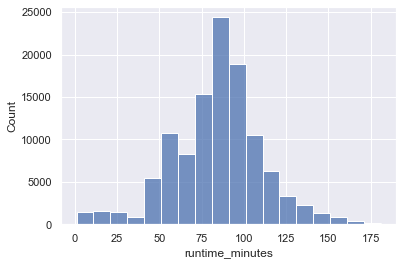

In [67]:
# Review distribution plot for runtime minutes
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

Notes:
- Small amount of movies had over 180 lengths
- Excluding these from historgram shows relatively normal distribution with median around 90.
- Some short runtimes <30 minutes probably data quality issues or documentaries.Investigate further if using runtime minutes for analysis

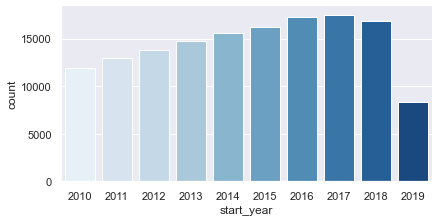

In [68]:
# Review distribution plot for movings by year
keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)

Notes:
- Years look complete except for 2019 data. Will limit analysis to 2010-2018 to ensure completeness of years when matching.

### IMDB Ratings Checks

In [69]:
# Check IMDB Ratings for duplication
imdb_ratings.info()
ratings_dups = imdb_ratings.duplicated(['tconst'],keep=False).sum()
print(f'{ratings_dups} dups on tconst')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tconst      73856 non-null  object 
 1   avg_rating  73856 non-null  float64
 2   num_votes   73856 non-null  Int64  
dtypes: Int64(1), float64(1), object(1)
memory usage: 1.8+ MB
0 dups on tconst


Note:
- Ratings has no duplicates, looks good

### BOM Movie Gross Checks

In [70]:
# BOM Movie Gross File - explore data quality
print(bom.info()) 
print(bom.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3387 non-null   Int64 
 3   foreign_gross   3387 non-null   Int64 
 4   year            3387 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 139.0+ KB
None
       domestic_gross  foreign_gross     year
count        3,387.00       3,387.00 3,387.00
mean    28,508,205.96  45,029,794.59 2,013.96
std     66,755,749.11 112,684,345.89     2.48
min              0.00           0.00 2,010.00
25%        111,500.00           0.00 2,012.00
50%      1,300,000.00   1,500,000.00 2,014.00
75%     27,500,000.00  29,150,000.00 2,016.00
max    936,700,000.00 960,500,000.00 2,018.00


In [71]:
# Validate range of values for year in BOM
bom['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)

2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: year, dtype: int64

Notes:
- Has data from 2010 through 2018 but title counts only in hundreds versus IMBD Basics in thousands
- Using this source will only have 5% of total titles; bias risk due to incompleteness

In [72]:
# Check range of values for studio in BOM
bom['studio'].value_counts(sort=True).head(10)

IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
SPC      123
Sony     110
BV       106
LGF      103
Par.     101
Name: studio, dtype: int64

Notes:
- Cryptic abbreviations for studio names. If using will need to translate via dictionary

In [73]:
# Confirm duplications of title in BOM
print(f"\n**{bom.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") 


**2 duplicates found based on title**



Notes:
- 2 duplicates in BOM, minor issue
- Will deduplicate if time remains

### TN Movie Budgets Checks

In [74]:
# TN Budgets File - how many records per year?
tn.groupby(by='year').size().sort_values(ascending=False).head(10)

year
2,015.00    338
2,010.00    274
2,008.00    264
2,006.00    260
2,014.00    255
2,011.00    254
2,013.00    238
2,009.00    238
2,012.00    235
2,005.00    223
dtype: int64

Notes:
- Similar to BOM file, only have few hundreds of largest movies in TN

In [75]:
# Check TN again for dupclicates
tn_dups = tn.duplicated(['movie','year'],keep=False).sum()
print(f'{tn_dups} duplicates found in TN based on movie and year')
tn[tn.duplicated(['movie','year'],keep=False)].head()

0 duplicates found in TN based on movie and year


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year


# Feature Engineering

This section includes code to combine raw dataframes from section 2 into analytical data frames that will be used for section 4 Business Analysis.

## Create Movies Dataframe

### Merge IMDB Basics + Ratings

In [76]:
# Create Movies dataframe - basics left join to ratings; set rating_ind for merge results
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')

# Drop unneeded column
movies.drop(columns=['original_title'], inplace=True)

# Set counter for each title and series rating_sum as product of votes and avg_rating; indicator of profitability?
movies['title_cnt'] = 1
movies['rating_sum'] = movies['num_votes'] * movies['avg_rating']

# Inspect a few rows
movies.head()

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.00,77,both,1,539.00
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.20,43,both,1,309.60
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.90,4517,both,1,"31,167.30"
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.10,13,both,1,79.30
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.50,119,both,1,773.50


### Deduplicate Movie Titles

In [77]:
# Check Movies for duplicate titles based on title-year key
dups = movies[movies.duplicated(subset=['primary_title','start_year'],keep=False)]
dups_cnt = len(dups)
print(f'{dups_cnt} duplicate titles found in movies')

# Sort values to display examples and prepare for de-dup logic
dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)
dups.head(10)

3942 duplicate titles found in movies


<ipython-input-77-4c2c75fb1c60>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups.sort_values(['primary_title','start_year','num_votes','runtime_minutes'], ascending=[True, True, True, True], na_position='first', inplace=True)


,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum
103890,tt6085916,(aguirre),2016,97,"Biography,Documentary",nan,<NA>,left_only,1,nan
106201,tt6214664,(aguirre),2016,98,"Biography,Comedy,Documentary",nan,<NA>,left_only,1,nan
129962,tt8032828,100 Milioni di bracciate,2017,<NA>,Biography,nan,<NA>,left_only,1,nan
129979,tt8034014,100 Milioni di bracciate,2017,<NA>,Biography,nan,<NA>,left_only,1,nan
24194,tt1979163,180,2011,107,"Comedy,Drama",7.40,42,both,1,310.80
20394,tt1855110,180,2011,121,"Drama,Romance",6.00,688,both,1,"4,128.00"
65431,tt3735338,1989,2014,54,Documentary,6.80,5,both,1,34.00
72121,tt4119270,1989,2014,97,"Documentary,History,Thriller",7.50,175,both,1,"1,312.50"
75495,tt4312624,21 Days,2014,70,Documentary,6.00,5,both,1,30.00
50212,tt2979366,21 Days,2014,89,"Horror,Thriller",4.50,454,both,1,"2,043.00"


Note:
- Duplicates have different tconst IDs so IMDB views them as unique
- No IMBD indicator on any files allow for filtering the primary title
- Will take tconst with highest number of votes (assumes most viewership), then by longest runtime (to filter out NA)

In [78]:
# Example movie Alice in Wonderland wtih dupcliate 2010 listings; we will want to keep tt1014759
display(movies[movies['primary_title']=='Alice in Wonderland'])

# Slice dataframe into rows to remove and keep, keeping the last record based on sort value above
dups_remove = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == True]
dups_keep = dups[dups.duplicated(subset=['primary_title','start_year'],keep='last') == False]

# Drop duplicat rows from movies
movies.drop(dups_remove.index, inplace = True)

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum
1608,tt1014759,Alice in Wonderland,2010,108,"Adventure,Family,Fantasy",6.50,358813,both,1,"2,332,284.50"
22538,tt1926979,Alice in Wonderland,2011,48,Documentary,nan,<NA>,left_only,1,nan
26279,tt2049386,Alice in Wonderland,2010,99,"Fantasy,Musical",6.50,6,both,1,39.00


In [79]:
# Validate that duplicates have been removed from movies data frame
dups_chk = movies[movies.duplicated(subset=['primary_title','start_year'],keep=False)]
dups_chk_cnt = len(dups_chk)
print(f'{dups_chk_cnt} duplicate titles found in movies')

# Review one duplicate
display(movies[movies['primary_title']=='Alice in Wonderland'])

0 duplicate titles found in movies


,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum
1608,tt1014759,Alice in Wonderland,2010,108,"Adventure,Family,Fantasy",6.50,358813,both,1,"2,332,284.50"
22538,tt1926979,Alice in Wonderland,2011,48,Documentary,nan,<NA>,left_only,1,nan


### Merge BOM Movie Gross

In [80]:
# Extend movies data frame to include BOM columns; drive merge as left outer join with gross_ind
movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')

# Drop duplicate columns not needed on matches
movies.drop(columns=['title','year'], inplace=True)

# Review some sample rows that merged
movies[movies['gross_ind']=='both'].head()

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum,studio,domestic_gross,foreign_gross,gross_ind
38,tt0315642,Wazir,2016,103,"Action,Crime,Drama",7.10,15378,both,1,"109,183.80",Relbig.,1100000,0,both
48,tt0337692,On the Road,2012,124,"Adventure,Drama,Romance",6.10,37886,both,1,"231,104.60",IFC,744000,8000000,both
54,tt0359950,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.30,275300,both,1,"2,009,690.00",Fox,58200000,129900000,both
58,tt0365907,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.50,105116,both,1,"683,254.00",Uni.,26300000,26900000,both
60,tt0369610,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.00,539338,both,1,"3,775,366.00",Uni.,652300000,1019,both


In [81]:
# Check merge results to assess completeness
movies.groupby(['rating_ind','gross_ind']).size()

rating_ind  gross_ind 
left_only   left_only     70537
            right_only        0
            both            264
right_only  left_only         0
            right_only        0
            both              0
both        left_only     70315
            right_only        0
            both           2958
dtype: int64

Notes:
- 3222 BOM titles were merged ('both')
- This represents only about 2.2% of the total titles in movies from IMDB
- Unfortunate to have such incompleteness, but appears BOM tracks the major movies so we should have most important titles

### Merge TN Movie Budgets

In [82]:
# Merge tn into movies using left outer join with tn_ind

# Set columns and keys from tn required to keep or faciliate join
keep = ['movie','year','production_budget','domestic_gross','worldwide_gross']
l_keys = ['start_year', 'primary_title']
r_keys = ['year','movie']

# Process merge using keys above, keeping columns in list
movies = movies.merge(tn[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='tn_ind')

# Drop duplicated movie and year columns after join; we have these from IMBD Basics already
movies.drop(columns=['movie','year'], inplace=True)

In [83]:
# Create some analytical measures
movies['worldwide_profit'] = movies['worldwide_gross'] - movies['production_budget'] # profit = sales - production costs
movies['profit_margin'] = (movies['worldwide_profit'] / movies['production_budget'])*100 # profit margin = profit / production costs
movies['is_profitable'] = movies['worldwide_profit'] > 0 # flag for profitable movies to use in plots
movies['gross_per_rating'] =  movies['worldwide_gross'] / movies['rating_sum'] # experimental predictive variable $ per rating point

# Review some sample rows that merged
movies[movies['tn_ind']=='both'].head()

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum,studio,domestic_gross_x,foreign_gross,gross_ind,production_budget,domestic_gross_y,worldwide_gross,tn_ind,worldwide_profit,profit_margin,is_profitable,gross_per_rating
20,tt0249516,Foodfight!,2012,91,"Action,Animation,Comedy",1.90,8248,both,1,"15,671.20",NaN,<NA>,<NA>,left_only,"45,000,000.00",0.00,"73,706.00",both,"-44,926,294.00",-99.84,False,4.70
54,tt0359950,The Secret Life of Walter Mitty,2013,114,"Adventure,Comedy,Drama",7.30,275300,both,1,"2,009,690.00",Fox,58200000,129900000,both,"91,000,000.00","58,236,838.00","187,861,183.00",both,"96,861,183.00",106.44,True,93.48
58,tt0365907,A Walk Among the Tombstones,2014,114,"Action,Crime,Drama",6.50,105116,both,1,"683,254.00",Uni.,26300000,26900000,both,"28,000,000.00","26,017,685.00","62,108,587.00",both,"34,108,587.00",121.82,True,90.90
60,tt0369610,Jurassic World,2015,124,"Action,Adventure,Sci-Fi",7.00,539338,both,1,"3,775,366.00",Uni.,652300000,1019,both,"215,000,000.00","652,270,625.00","1,648,854,864.00",both,"1,433,854,864.00",666.91,True,436.74
62,tt0376136,The Rum Diary,2011,119,"Comedy,Drama",6.20,94787,both,1,"587,679.40",FD,13100000,10800000,both,"45,000,000.00","13,109,815.00","21,544,732.00",both,"-23,455,268.00",-52.12,False,36.66


In [84]:
# Check potential matches between movies and tn (both already de-duplicated above)
tn_cnts = tn[tn['year'].between(2010,2018)].movie.size
movie_cnts = movies[movies['start_year'].between(2010,2018)].primary_title.size

print(f'For years 2010-2018, TN file has {tn_cnts} unique titles. IMDB Basics has {movie_cnts}.')
display(movies['tn_ind'].value_counts())

For years 2010-2018, TN file has 2124 unique titles. IMDB Basics has 134736.


left_only     142590
both            1484
right_only         0
Name: tn_ind, dtype: int64

Notes:
- Of 2124 titles, only 1484 matched (69.9%). Of Movies, only about 1% of titles have TN match.
- Similar to BOM, only the largest movies are contained in TN. Use with caveat on population coverage.

### Reverse Match TN Movie Budgets

In [85]:
# Reverse join driving off TN to identify non-matches to movies

# Set columns and keys from tn required to keep or faciliate reverse join to movies
keep = ['primary_title','start_year','tn_ind']
r_keys = ['start_year', 'primary_title']
l_keys = ['year','movie']
tn_reverse = tn.merge(movies[keep], how='left', left_on=l_keys, right_on=r_keys, indicator='movies_ind')

In [86]:
# Review reverse match results
display(tn_reverse[tn_reverse['year'].between(2010,2018)]['movies_ind'].value_counts())

both          1442
left_only      682
right_only       0
Name: movies_ind, dtype: int64

In [87]:
# List examples of tn rows not matching to movies
tn_reverse[tn_reverse['movies_ind']=='left_only'].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,primary_title,start_year,tn_ind,movies_ind
0,1.00,2009-12-18,Avatar,"425,000,000.00","760,507,625.00","2,776,345,279.00","2,009.00",NaN,nan,NaN,left_only
4,5.00,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"317,000,000.00","620,181,382.00","1,316,721,747.00","2,017.00",NaN,nan,NaN,left_only
5,6.00,2015-12-18,Star Wars Ep. VII: The Force Awakens,"306,000,000.00","936,662,225.00","2,053,311,220.00","2,015.00",NaN,nan,NaN,left_only
7,8.00,2007-05-24,Pirates of the Caribbean: At Worlds End,"300,000,000.00","309,420,425.00","963,420,425.00","2,007.00",NaN,nan,NaN,left_only
15,16.00,2007-05-04,Spider-Man 3,"258,000,000.00","336,530,303.00","894,860,230.00","2,007.00",NaN,nan,NaN,left_only
19,20.00,2009-07-15,Harry Potter and the Half-Blood Prince,"250,000,000.00","302,089,278.00","935,213,767.00","2,009.00",NaN,nan,NaN,left_only
23,24.00,2006-06-28,Superman Returns,"232,000,000.00","200,120,000.00","374,085,065.00","2,006.00",NaN,nan,NaN,left_only
25,26.00,2008-11-14,Quantum of Solace,"230,000,000.00","169,368,427.00","591,692,078.00","2,008.00",NaN,nan,NaN,left_only
27,28.00,2006-07-07,Pirates of the Caribbean: Dead Mans Chest,"225,000,000.00","423,315,812.00","1,066,215,812.00","2,006.00",NaN,nan,NaN,left_only
29,30.00,2008-05-16,The Chronicles of Narnia: Prince Caspian,"225,000,000.00","141,621,490.00","417,341,288.00","2,008.00",NaN,nan,NaN,left_only


Notes:
- Many of the movies are quite large and would like to pick them up
- Many appear to have slight formatting differences versus movies such as special characters, abbreviations or name differences
- Using fuzzy match could likely enable joining of these records https://pbpython.com/record-linking.html (research at later date)

## Create Principals Dataframe

In [88]:
# Merge movies into principals (prin) for actor analysis

# Establish copy of movies for records that have BOM matches (gross_ind)
movies_slim = movies[ (movies['start_year'].between(2010,2018)) & (movies['gross_ind']=='both') ]

# Merge via inner join prin and movies_slim, setting mov_ind on join
prin = prin.merge(movies_slim, how='inner', left_on='tconst', right_on='tconst', indicator='mov_ind')

# Set worldwide gross column as sum of domestic and foreign gross sales
prin['ww_gross'] = prin['domestic_gross_x'] + prin['foreign_gross']

# Check a few rows to see how it looks
prin.head()

,tconst,nconst,category,primary_name,peop_ind,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,title_cnt,rating_sum,studio,domestic_gross_x,foreign_gross,gross_ind,production_budget,domestic_gross_y,worldwide_gross,tn_ind,worldwide_profit,profit_margin,is_profitable,gross_per_rating,mov_ind,ww_gross
0,tt0475290,nm0000982,actor,Josh Brolin,both,"Hail, Caesar!",2016,106,"Comedy,Drama,Music",6.30,111422,both,1,"701,958.60",Uni.,30500000,33100000,both,"22,000,000.00","30,080,225.00","64,160,680.00",both,"42,160,680.00",191.64,True,91.40,both,63600000
1,tt0475290,nm0000123,actor,George Clooney,both,"Hail, Caesar!",2016,106,"Comedy,Drama,Music",6.30,111422,both,1,"701,958.60",Uni.,30500000,33100000,both,"22,000,000.00","30,080,225.00","64,160,680.00",both,"42,160,680.00",191.64,True,91.40,both,63600000
2,tt0475290,nm2403277,actor,Alden Ehrenreich,both,"Hail, Caesar!",2016,106,"Comedy,Drama,Music",6.30,111422,both,1,"701,958.60",Uni.,30500000,33100000,both,"22,000,000.00","30,080,225.00","64,160,680.00",both,"42,160,680.00",191.64,True,91.40,both,63600000
3,tt0475290,nm0000146,actor,Ralph Fiennes,both,"Hail, Caesar!",2016,106,"Comedy,Drama,Music",6.30,111422,both,1,"701,958.60",Uni.,30500000,33100000,both,"22,000,000.00","30,080,225.00","64,160,680.00",both,"42,160,680.00",191.64,True,91.40,both,63600000
4,tt1075747,nm0000982,actor,Josh Brolin,both,Jonah Hex,2010,81,"Action,Drama,Fantasy",4.70,51860,both,1,"243,742.00",WB,10500000,356000,both,"47,000,000.00","10,547,117.00","11,022,696.00",both,"-35,977,304.00",-76.55,False,45.22,both,10856000


Notes:
- prin data frame measures (eg. gross) is not additive since movie data repeats for every actor associated with title
- Using BOM columns instead of TN due to higher match rate from previous analysis since i don't need production costs here

In [89]:
# Create data frame 'top' grouped by actor for use in plotting; agg key metrics
top = prin.groupby('primary_name', as_index=False).agg(movie_count = ('title_cnt', 'sum'), 
                                                        domestic_gross = ('domestic_gross_x',  'sum'),
                                                        foreign_gross = ('foreign_gross', 'sum'),
                                                        ww_gross = ('ww_gross', 'sum')
                                                       ).sort_values('movie_count', ascending=False)

# Create metric worldwide gross per movie each actor was in and sort descending by total worldwide gross
top['ww_gross_per_movie'] = top['ww_gross'] / top['movie_count']
top = top.sort_values(['ww_gross'], ascending=False)

# Display top few actors in 2010-2018 data
top.head()

,primary_name,movie_count,domestic_gross,foreign_gross,ww_gross,ww_gross_per_movie
3204,Robert Downey Jr.,10,2967300000,3876501370,6843801370,"684,380,137.00"
1015,Dwayne Johnson,15,2442400000,3232402173,5674802173,"378,320,144.87"
634,Chris Hemsworth,11,2164900000,2676201370,4841101370,"440,100,124.55"
631,Chris Evans,11,2049506100,2462601369,4512107469,"410,191,588.09"
1921,Johnny Depp,13,1160000000,3028000000,4188000000,"322,153,846.15"


## Drop unused data frames

In [90]:
# Check how many large objects we've accumulated
memory_usage()

,Size
movies,52.47MB
keepyears,49.63MB
imdb_basics,43.69MB
length180,35.02MB
imdb_ratings,5.99MB
prin,4.60MB
year_filter,1.27MB
movies_slim,1.24MB
tn_reverse,1.02MB
dups,1.00MB


In [91]:
# Delete staging data frames that have been merged and are not needed
del keepyears
del imdb_basics
del length180
del imdb_ratings
del tn_reverse
del tn
del bom
del dups_remove
del dups_keep

In [92]:
# Call garbage collector to release object memory
gc.collect()

147

In [93]:
# Re-check how many large objects we've accumulated
memory_usage()

,Size
movies,52.47MB
prin,4.60MB
year_filter,1.27MB
movies_slim,1.24MB
dups,1.00MB
top,497.64KB
_88,4.32KB
_38,4.20KB
_28,2.86KB
_77,2.86KB


# Business Analysis

This section of the notebook includes analysis, plots and insights into existing movies data. Not every analysis turned into a recommendation, but all useful analyses were kept in the notebook for background context.

## Genre Analysis

One of best and most relevant attributes we have is which genres have done well and which to recommend to Microsoft. This section includes several views of genres.
Profits are calculated as follows from TN data:
- Profits = Worldwide Sales - Production Costs
- Profit Margins = Profits / Production Costs

Note: Sales and costs are not adjusted by CPI factor since it's only a 8-year period following the Great Recession when inflation was near zero.

### Group By Genres

In [94]:
# Top movie genres 2010-2018 - Movie Counts and % of Total Titles
# This view has genres as provided by IMBD which has combination values like 'Comedy,Drama'

# Establish range of years based on data quality across movies sources
year_filter = movies['start_year'].between(2010,2018)

# Create a group by genres for the Top 20 values descending; Add subtotal of all movies and % of total for each row
titles = movies[year_filter].groupby('genres', as_index=False).agg(Movie_Count = ('title_cnt', 'sum')).sort_values('Movie_Count', ascending=False)[:20]
titles['Subtotal'] = movies[year_filter].title_cnt.sum()
titles['Pct_Total'] = (titles['Movie_Count']*100 / titles['Subtotal'])
print(titles)

                             genres  Movie_Count  Subtotal  Pct_Total
685                     Documentary        30023    134736      22.28
783                           Drama        19467    134736      14.45
486                          Comedy         8372    134736       6.21
976                          Horror         3877    134736       2.88
519                    Comedy,Drama         3236    134736       2.40
1058                       Thriller         2564    134736       1.90
426           Biography,Documentary         2045    134736       1.52
0                            Action         1945    134736       1.44
861                   Drama,Romance         1941    134736       1.44
686               Documentary,Drama         1501    134736       1.11
529            Comedy,Drama,Romance         1488    134736       1.10
599                  Comedy,Romance         1403    134736       1.04
741               Documentary,Music         1318    134736       0.98
1041                

Notes:
- 134,736 titles in total for IMDB movies for 2010-2018
- Documentaries are by far most prevelant, likely due to lower costs/runtimes and lack of star actors
- Drama and Comedy are 2nd and 3rd most prevelent genres. Top 3 categories reflect 43% of total movies.
- Remaining categories range from 0-3% each, with significant multi-genre listings
- Multi-genre listings (Comedy, Drama) are important but dilute the "pure intent" of draft. Need to look at unique genres too.

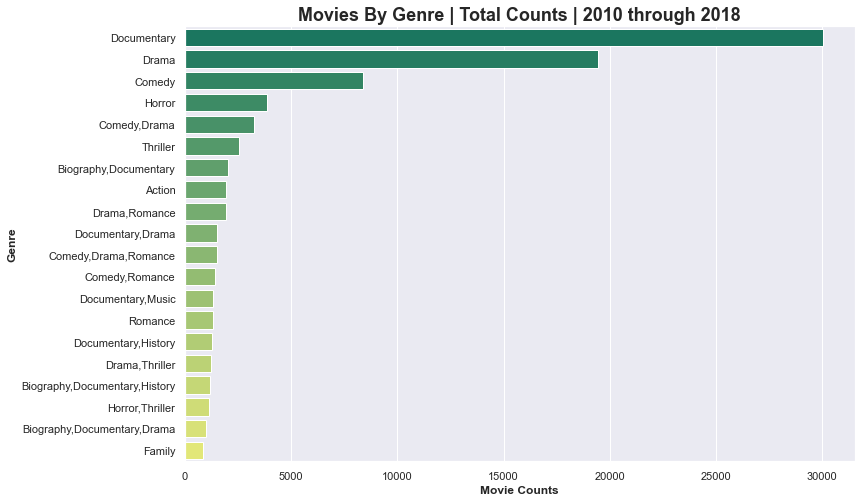

In [95]:
# Plot the top 20 genres by title count from 2010-2018 using titles group by slice
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(data = titles, orient='h', x = 'Movie_Count', y = 'genres', palette='summer')
ax.set_title('Movies By Genre | Total Counts | 2010 through 2018', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
plt.show()

### Group By Unique Genre

In [96]:
# Take a slice of movies 2010-2018 to create a derived data frame g_cnt_der that deals with multiple genre issue

# Select a subset of movies columns for g_cnt_der
g_cnt_der = movies[['tconst', 'primary_title', 'start_year', 'genres', 'title_cnt', 'runtime_minutes', 'rating_ind', 
                    'avg_rating', 'num_votes', 'rating_sum', 'gross_per_rating', 'tn_ind', 'production_budget', 'domestic_gross_y', 
                    'worldwide_gross', 'worldwide_profit', 'profit_margin', 'is_profitable']]

# Split genres column in place using ',' delimeter - creating a list series
g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')

# Create a new series column for the number of genres that each row has; 'Comedy,Drama' would equal 2
g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()

# Explode the genres to rows in data frame, allowing a single movie to be directly tagged to multiple geners in some cases
g_cnt_der = g_cnt_der.explode('genres')

# Create a new measure, allocating a single title count (=1) to multiple genres by formula
g_cnt_der['title_cnt_der'] = g_cnt_der['title_cnt'] / g_cnt_der['num_genres']

# Suppress 11 genres from consideration in analysis. See Notes below
genre_suppress = ['Reality-TV','Talk-Show','Adult','Short','Game-Show','War','Horror','Western','News','Musical','Documentary']

# Overwrite data frame, filtered to 2010-2018 and only for non-suppressed geners
g_cnt_der = g_cnt_der[(g_cnt_der.start_year.between(2010,2018)) & (~g_cnt_der.genres.isin(genre_suppress))]

# View a view records to validate
g_cnt_der.head()

<ipython-input-96-4a1d90439096>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['genres'] = g_cnt_der['genres'].str.split(',')
<ipython-input-96-4a1d90439096>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_cnt_der['num_genres'] = g_cnt_der['genres'].str.len()


,tconst,primary_title,start_year,genres,title_cnt,runtime_minutes,rating_ind,avg_rating,num_votes,rating_sum,gross_per_rating,tn_ind,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,is_profitable,num_genres,title_cnt_der
0,tt0063540,Sunghursh,2013,Action,1,175,both,7.00,77,539.00,nan,left_only,nan,nan,nan,nan,nan,False,3.00,0.33
0,tt0063540,Sunghursh,2013,Crime,1,175,both,7.00,77,539.00,nan,left_only,nan,nan,nan,nan,nan,False,3.00,0.33
0,tt0063540,Sunghursh,2013,Drama,1,175,both,7.00,77,539.00,nan,left_only,nan,nan,nan,nan,nan,False,3.00,0.33
2,tt0069049,The Other Side of the Wind,2018,Drama,1,122,both,6.90,4517,"31,167.30",nan,left_only,nan,nan,nan,nan,nan,False,1.00,1.00
3,tt0069204,Sabse Bada Sukh,2018,Comedy,1,<NA>,both,6.10,13,79.30,nan,left_only,nan,nan,nan,nan,nan,False,2.00,0.50


Notes:
- Exploding generes approach will enable us to report by single genre values with allocations for movies that split genres
- In cases of split movie like 'Action,Crime,Drama' in Sunghursh: each genre would register 0.3333 title counts still summing to one
- Other metrics like gross and budget were not allocated, so would sum incorrectly but could be used for means

In [97]:
# Create new column to map genres to 3 super-genres Special, Traditional and Reference 
supergenre_dict = {'Action':'Special', 'Sci-Fi':'Special','Thriller':'Special','Mystery':'Special',
                   'Adventure':'Special','Fantasy':'Special','Animation':'Traditional','Family':'Traditional',
                   'Comedy':'Traditional','Drama':'Traditional','Crime':'Traditional','Romance':'Traditional',
                   'Music':'Reference','Documentary':'Reference','Sport':'Reference','History':'Reference',
                   'Biography':'Reference'}
g_cnt_der['super_genre']= g_cnt_der['genres'].map(supergenre_dict)

Notes:
- Super genre was created to simplify grouping of approx. 20 genres values into like categories
- This is a custom hierarchy I created based on likeness of genres
    - Special: Higher technology, action-oriented and special effects
    - Traditional: Drama or comedy-based, more traditional stories
    - Reference: Speciality movies around a niche area like music, sports or history; contains some non-fiction

In [98]:
# Create a sorted group by genre for non-suppressed values; Add subtotal of all movies and % of total for each row
titles_der = g_cnt_der.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])

# Let's take a look
titles_der

,genres,movie_count,avg_runtime_mins,avg_rating_avg,num_votes_avg,total_movies,pct_total
6,Drama,"30,340.67",94.23,6.39,"4,011.69","83,405.17",36.38
4,Comedy,"14,642.17",93.91,5.99,"4,423.51","83,405.17",17.56
15,Thriller,"5,868.50",94.36,5.62,"6,042.25","83,405.17",7.04
0,Action,"4,747.50",99.97,5.80,"14,764.85","83,405.17",5.69
12,Romance,"4,400.17",100.20,6.13,"4,189.58","83,405.17",5.28
3,Biography,"3,482.17",73.84,7.16,"5,769.93","83,405.17",4.18
7,Family,"2,790.67",82.93,6.38,"2,583.33","83,405.17",3.35
5,Crime,"2,710.83",95.41,6.10,"8,819.57","83,405.17",3.25
9,History,"2,525.50",78.49,7.04,"2,819.92","83,405.17",3.03
1,Adventure,"2,438.17",85.62,6.18,"22,430.00","83,405.17",2.92


Notes:
- After allocating mixed genres, Drama went up from 19K to 30K titles and Comedy from 8K to 14K
- This view simplifies genres down to 16 categories and makes it clear which titles are dominant
- I'll be using this genre approach for my analysis to eliminate mixed genre categories
- Mixed genres are indeed important, but due to time constraints we'll focus on single genre analysis

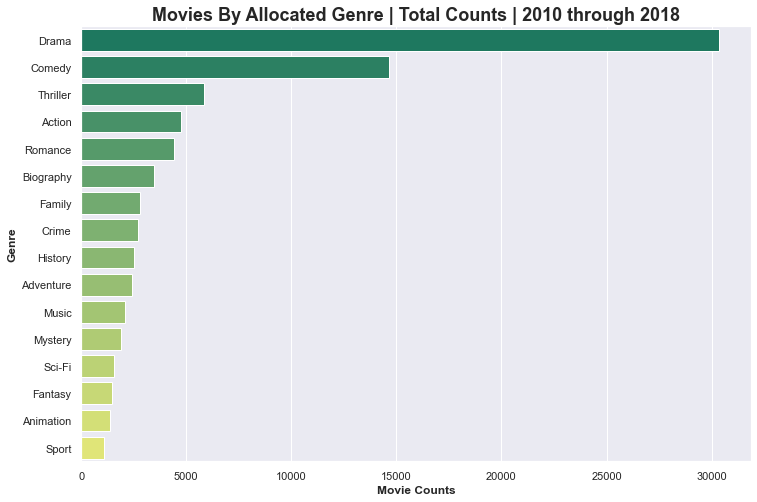

In [99]:
# Plot the top 20 unique genres by title count from 2010-2018 using titles group by slice
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer')
ax.set_title('Movies By Allocated Genre | Total Counts | 2010 through 2018', fontdict= {'fontsize': 18, 'fontweight':'bold'})
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) 
plt.show()
# Possibly add cumulative % 2nd axis

### Counts & Runtimes By Genre

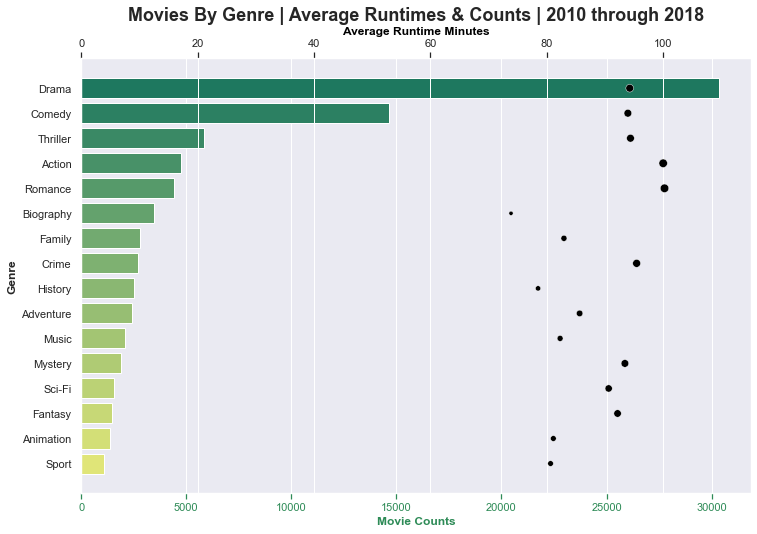

<Figure size 864x576 with 0 Axes>

In [100]:
# Plot the top 22 genres by movie count and runtime minutes from 2010-2018
sns.set(rc={'figure.figsize':(12,8)}) # establish 12x8 inch layout
ax_color = 'seagreen' # set color
ax = sns.barplot(data = titles_der, orient='h', x = 'movie_count', y = 'genres', palette='summer') # seaborn barplot object

# Format x-axis options
ax.set_xlabel('Movie Counts', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) # set x-axis label and font
ax.xaxis.label.set_color(ax_color) # set x-axis label color to align with bar chart color
ax.tick_params(axis='x', colors=ax_color) # set x-axis ticks color to align with bar chart color
ax.set_xlim(0, None) # anchor x at 0

# Format y-axis and title
ax.set_title('Movies By Genre | Average Runtimes & Counts | 2010 through 2018', fontdict= {'fontsize': 18, 'fontweight':'bold'}) # plot title
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) # set x-axis label color to align with scatter circle color

# specify we want to share the same x-axis on dual-axis chart
ax2 = ax.twiny()
ax2_color = 'black' # set dual (top) x-axis color
ax2 = sns.scatterplot(data = titles_der, x = 'avg_runtime_mins', y = 'genres', color=ax2_color, size='avg_runtime_mins', legend=False) # seaborn scatterplot object
ax2.set_xlim(0, 115) # anchor top x at 0, limit to 115
ax2.set_xlabel('Average Runtime Minutes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color) # set top x-axis label and font
plt.show() # show plot

plt.savefig('movies-by-genre.png', orientation="landscape", dpi=300)

### Ratings By Genre Chart

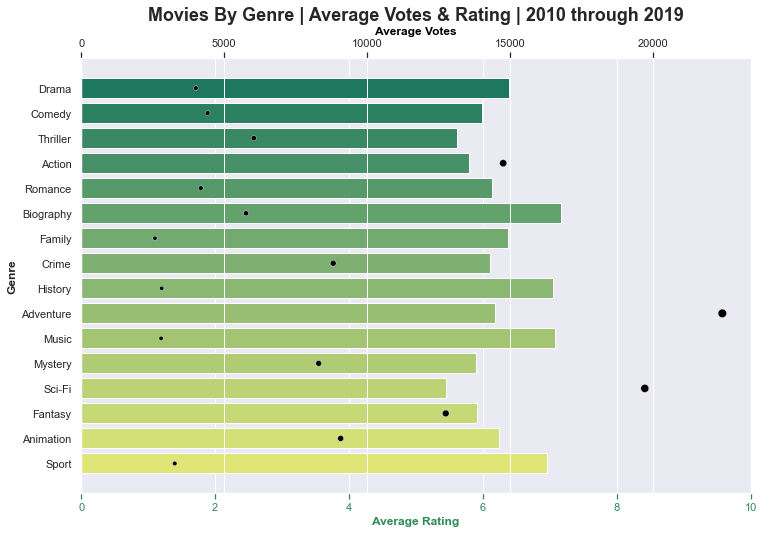

In [101]:
# Plot the top 22 genres by average movie rating and votes from 2010-2018
sns.set(rc={'figure.figsize':(12,8)}) # establish 12x8 inch layout
ax_color = 'seagreen' # set color
ax = sns.barplot(data = titles_der, orient='h', x = 'avg_rating_avg', y = 'genres', palette='summer') # seaborn barplot object

# Format x-axis options
ax.set_xlabel('Average Rating', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax_color) # set x-axis label and font
ax.xaxis.label.set_color(ax_color) # set x-axis label color to align with bar chart color
ax.tick_params(axis='x', colors=ax_color) # set x-axis ticks color to align with bar chart color
ax.set_xlim(0, 10) # anchor x at 0 to 10 span

# Format y-axis and title
ax.set_title('Movies By Genre | Average Votes & Rating | 2010 through 2019', fontdict= {'fontsize': 18, 'fontweight':'bold'}) # plot title
ax.set_ylabel('Genre', fontdict= {'fontsize': 12, 'fontweight':'bold'}) # set x-axis label color to align with scatter circle color

## specify we want to share the same x-axis on dual-axis chart
ax2 = ax.twiny()
ax2_color = 'black' # set dual (top) x-axis color
ax2 = sns.scatterplot(data = titles_der, x = 'num_votes_avg', y = 'genres', color=ax2_color, size='num_votes_avg', legend=False) # seaborn scatterplot object
ax2.set_xlim(0, None) # anchor top x at 0, no limit top end
ax2.set_xlabel('Average Votes', fontdict= {'fontsize': 12, 'fontweight':'bold'}, color=ax2_color) # set top x-axis label and font

plt.show() # show plot

## Genre Profit Correlation

In [102]:
# Convert profits columns using weighted counts (similar to movie counts)
g_cnt_der['production_budget_der'] = g_cnt_der['production_budget'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_gross_der'] = g_cnt_der['worldwide_gross'] / g_cnt_der['num_genres']
g_cnt_der['worldwide_profit_der'] = g_cnt_der['worldwide_profit'] / g_cnt_der['num_genres']

# Create another slide of g_cnt_der where tn budget data is available for profit analysis
profits = g_cnt_der[g_cnt_der['tn_ind'] == 'both']
profits_len = len(profits.tconst.unique())
display(f'{profits_len} titles are included in profits data frame')
profits.head()

'1402 titles are included in profits data frame'

,tconst,primary_title,start_year,genres,title_cnt,runtime_minutes,rating_ind,avg_rating,num_votes,rating_sum,gross_per_rating,tn_ind,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,is_profitable,num_genres,title_cnt_der,super_genre,production_budget_der,worldwide_gross_der,worldwide_profit_der
20,tt0249516,Foodfight!,2012,Action,1,91,both,1.90,8248,"15,671.20",4.70,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,False,3.00,0.33,Special,"15,000,000.00","24,568.67","-14,975,431.33"
20,tt0249516,Foodfight!,2012,Animation,1,91,both,1.90,8248,"15,671.20",4.70,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,False,3.00,0.33,Traditional,"15,000,000.00","24,568.67","-14,975,431.33"
20,tt0249516,Foodfight!,2012,Comedy,1,91,both,1.90,8248,"15,671.20",4.70,both,"45,000,000.00",0.00,"73,706.00","-44,926,294.00",-99.84,False,3.00,0.33,Traditional,"15,000,000.00","24,568.67","-14,975,431.33"
54,tt0359950,The Secret Life of Walter Mitty,2013,Adventure,1,114,both,7.30,275300,"2,009,690.00",93.48,both,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00",106.44,True,3.00,0.33,Special,"30,333,333.33","62,620,394.33","32,287,061.00"
54,tt0359950,The Secret Life of Walter Mitty,2013,Comedy,1,114,both,7.30,275300,"2,009,690.00",93.48,both,"91,000,000.00","58,236,838.00","187,861,183.00","96,861,183.00",106.44,True,3.00,0.33,Traditional,"30,333,333.33","62,620,394.33","32,287,061.00"


In [103]:
# Create a sorted group by genre for non-suppressed values; Add subtotal of all movies and % of total for each row
profits_der = profits.groupby('genres', as_index=False).agg(movie_count = ('title_cnt_der', 'sum'), avg_runtime_mins = ('runtime_minutes', 'mean'), avg_rating_avg = ('avg_rating', 'mean'), num_votes_avg = ('num_votes', 'mean')).sort_values('movie_count', ascending=False)
titles_der['total_movies'] = titles_der['movie_count'].sum()
titles_der['pct_total'] = (titles_der['movie_count']*100 / titles_der['total_movies'])

# Let's take a look
titles_der

,genres,movie_count,avg_runtime_mins,avg_rating_avg,num_votes_avg,total_movies,pct_total
6,Drama,"30,340.67",94.23,6.39,"4,011.69","83,405.17",36.38
4,Comedy,"14,642.17",93.91,5.99,"4,423.51","83,405.17",17.56
15,Thriller,"5,868.50",94.36,5.62,"6,042.25","83,405.17",7.04
0,Action,"4,747.50",99.97,5.80,"14,764.85","83,405.17",5.69
12,Romance,"4,400.17",100.20,6.13,"4,189.58","83,405.17",5.28
3,Biography,"3,482.17",73.84,7.16,"5,769.93","83,405.17",4.18
7,Family,"2,790.67",82.93,6.38,"2,583.33","83,405.17",3.35
5,Crime,"2,710.83",95.41,6.10,"8,819.57","83,405.17",3.25
9,History,"2,525.50",78.49,7.04,"2,819.92","83,405.17",3.03
1,Adventure,"2,438.17",85.62,6.18,"22,430.00","83,405.17",2.92


In [117]:
profits.groupby('genres')['worldwide_gross','worldwide_profit'].describe()

<ipython-input-117-744048a98c35>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  profits.groupby('genres')['worldwide_gross','worldwide_profit'].describe()


worldwide_gross                                           \
                    count           mean            std        min   
genres                                                               
Action             435.00 239,082,441.00 312,484,480.74       0.00   
Adventure          336.00 353,641,389.70 349,374,398.85       0.00   
Animation           97.00 384,800,343.13 315,378,134.86       0.00   
Biography          129.00  82,637,733.37 124,089,232.77       0.00   
Comedy             500.00 134,041,582.77 203,150,029.40       0.00   
Crime              228.00  81,722,461.95 151,762,337.24       0.00   
Drama              705.00  73,515,265.80 118,423,346.40       0.00   
Family              88.00 195,019,390.99 264,359,174.32       0.00   
Fantasy            117.00 239,083,985.26 304,173,282.80       0.00   
History             38.00  89,865,179.50 103,069,123.58 173,472.00   
Music               47.00  75,450,164.68 146,608,153.75       0.00   
Mystery            117.00  92,557,113.89 109,662,122.25       0.00   
Romance            182.00  68,246,865.76  88,625,161.61       0.00   
Sci-Fi             127.00 346,552,698.93 404,997,948.48       0.00   
Sport               33.00  53,039,394.82  56,881,237.09       0.00   
Thriller           253.00 114,805,822.08 199,514,720.60       0.00   

                                                                         \
                     25%            50%            75%              max   
genres                                                                    
Action     30,345,581.00 121,778,347.00 318,930,021.50 2,048,134,200.00   
Adventure  82,418,477.00 244,358,494.00 533,619,587.25 2,048,134,200.00   
Animation 126,577,874.00 321,887,208.00 554,987,477.00 1,272,469,910.00   
Biography  10,116,816.00  37,119,358.00  98,837,872.00   894,985,342.00   
Comedy     13,196,302.25  61,536,477.00 156,658,833.25 1,272,469,910.00   
Crime       7,952,980.00  41,217,161.00  94,506,750.50 1,518,722,794.00   
Drama       5,046,038.00  32,398,681.00  87,145,086.00   962,854,547.00   
Family     26,919,385.75  91,593,704.00 239,711,996.25 1,259,199,706.00   
Fantasy    26,121,638.00  91,678,442.00 330,780,051.00 1,259,199,706.00   
History    12,733,906.50  47,993,747.00 158,230,943.25   499,837,368.00   
Music       8,184,020.50  31,157,914.00  84,454,422.50   894,985,342.00   
Mystery    15,824,374.00  51,723,644.00 113,402,302.00   586,464,305.00   
Romance     6,672,904.50  37,682,552.00  93,707,950.25   570,998,101.00   
Sci-Fi     30,709,697.50 220,796,009.00 529,303,392.00 2,048,134,200.00   
Sport       8,300,821.00  30,138,912.00  73,239,258.00   213,591,522.00   
Thriller    6,328,516.00  48,164,150.00 136,123,083.00 1,518,722,794.00   

          worldwide_profit                                                \
                     count           mean            std             min   
genres                                                                     
Action              435.00 160,958,441.00 260,820,183.61  -90,000,000.00   
Adventure           336.00 248,178,770.65 300,619,219.52 -110,450,242.00   
Animation            97.00 286,949,827.67 283,099,892.94 -110,450,242.00   
Biography           129.00  56,486,415.54 112,563,070.96  -32,125,078.00   
Comedy              500.00  94,197,692.77 172,359,721.11  -60,000,000.00   
Crime               228.00  49,343,690.02 128,672,079.49  -90,000,000.00   
Drama               705.00  46,839,777.92  99,453,095.64  -79,448,583.00   
Family               88.00 128,973,936.44 220,261,529.89 -110,450,242.00   
Fantasy             117.00 154,923,728.85 244,383,151.05  -90,000,000.00   
History              38.00  53,602,021.61  85,916,959.39  -41,995,779.00   
Music                47.00  58,142,717.87 138,959,750.63  -11,613,847.00   
Mystery             117.00  67,432,561.32  93,120,140.13  -19,126,383.00   
Romance             182.00  45,841,151.47  75,037,876.12  -25,864,564.00   
Sci-Fi              127.00 253,584,98

In [116]:

profits.groupby('genres')['worldwide_profit'].std() / profits.groupby('genres')['worldwide_profit'].mean()

genres
Action      1.62
Adventure   1.21
Animation   0.99
Biography   1.99
Comedy      1.83
Crime       2.61
Drama       2.12
Family      1.71
Fantasy     1.58
History     1.60
Music       2.39
Mystery     1.38
Romance     1.64
Sci-Fi      1.35
Sport       1.59
Thriller    2.04
Name: worldwide_profit, dtype: float64

In [118]:
profits.groupby('genres')['worldwide_gross'].std() / profits.groupby('genres')['worldwide_gross'].mean()

genres
Action      1.31
Adventure   0.99
Animation   0.82
Biography   1.50
Comedy      1.52
Crime       1.86
Drama       1.61
Family      1.36
Fantasy     1.27
History     1.15
Music       1.94
Mystery     1.18
Romance     1.30
Sci-Fi      1.17
Sport       1.07
Thriller    1.74
Name: worldwide_gross, dtype: float64

/Users/cutterback/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


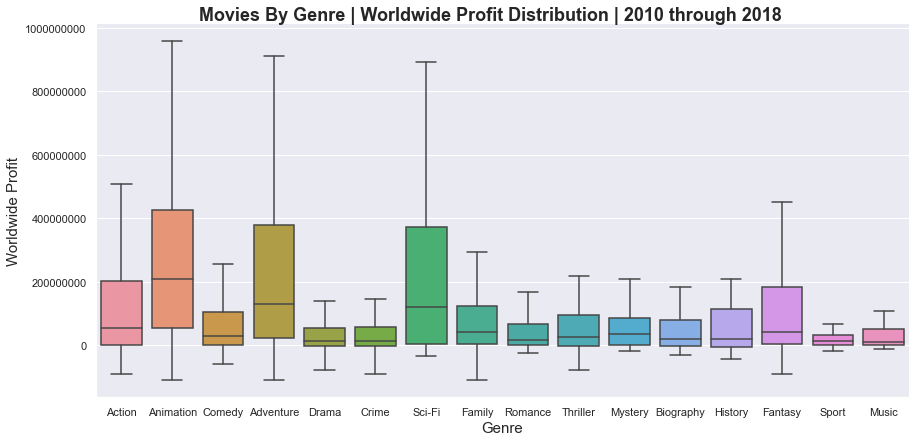

In [200]:
# Create a box plot by genre to show distribution of profits
sns.set(style="darkgrid")
box_profit = sns.catplot(kind='box', data=profits, x="genres", y="worldwide_profit", ax=ax, height=6, aspect=2, showfliers=False) # seaborn catplot object

# Set formatting for labels
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Genre', fontsize=15)
plt.ylabel('Worldwide Profit', fontsize=15)
plt.subplots_adjust(top=0.94) # Whitespace so title doesn't overlap grid
box_profit.fig.suptitle('Movies By Genre | Worldwide Profit Distribution | 2010 through 2018', fontsize = 18, fontweight ="bold") # set title

plt.show()

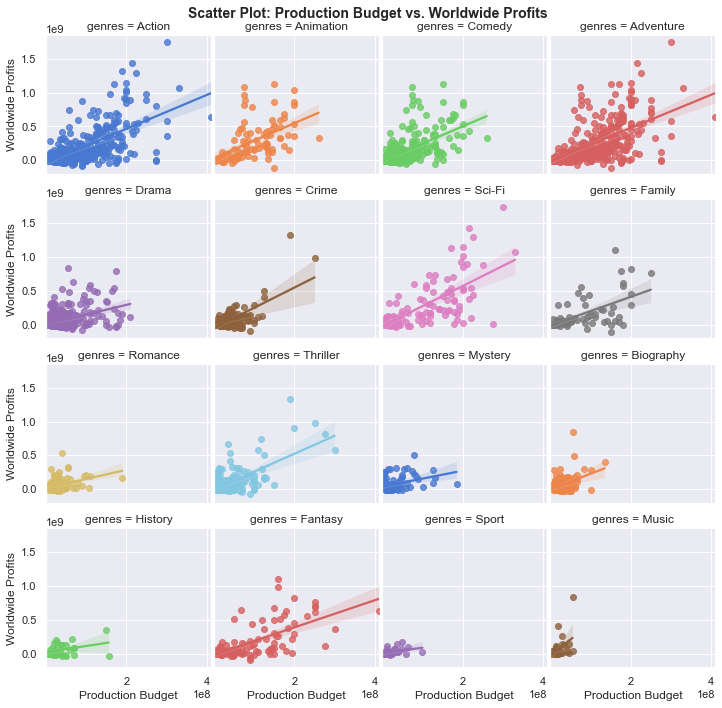

In [105]:
# Create scatter subplots by genre comparing budget to worlwide profit. The regression slope indicates correlation between measures
sns.set(style='darkgrid')
s = sns.lmplot(data=profits, x='production_budget', y='worldwide_profit', hue='genres', palette="muted", 
               height=2.5, col="genres", col_wrap=4, legend_out=True, sharey=True) # seaborn lmplot object (scatter with facet)

plt.subplots_adjust(top=0.94) # Whitespace so title doesn't overlap grid
s.fig.suptitle('Scatter Plot: Production Budget vs. Worldwide Profits', fontsize=14, fontweight='bold') # set title
s.set_axis_labels('Production Budget', 'Worldwide Profits') # set axis labels
s.fig.subplots_adjust(wspace=.02) # set level of whitespace padding between plots

## Budget Size

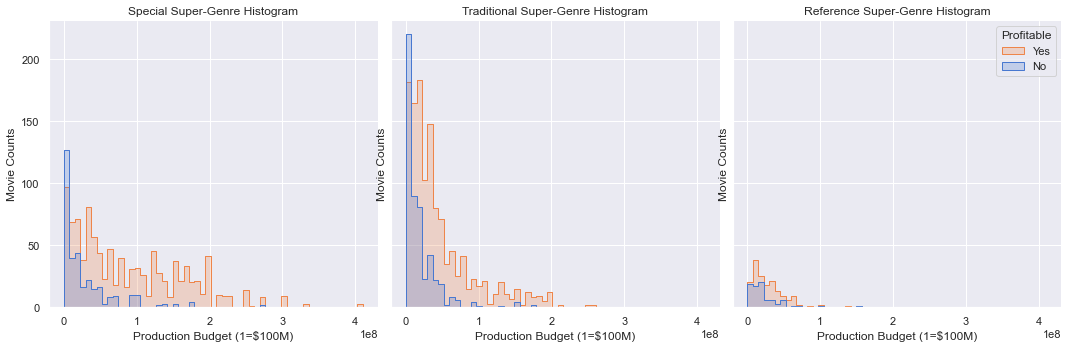

In [155]:
# Create histogram for budget bins, showing count of movies; overlay profitability indicator and super-genre

s = sns.displot(data=profits, x='production_budget', col='super_genre', hue='is_profitable', kind='hist', 
            palette='muted', element="step", legend=False) # seaborn displot (multi-histograms)
s.set_titles("{col_name} Super-Genre Histogram")
s.set(xlabel='Production Budget (1=$100M)', ylabel='Movie Counts') # set title and labels
plt.legend(title='Profitable', labels=['Yes', 'No'])
plt.show()

In [156]:
profits2 = profits[profits['production_budget']<=300000000]
profits2['budget_bin'] = pd.cut(profits2.production_budget, bins=8, labels=['1','2','3','4','5','6','7','8'])
profits2['budget_bin2'] = pd.cut(profits2.production_budget, bins=8)
group = profits2.groupby(['super_genre','budget_bin'])['worldwide_profit'].std() / profits2.groupby(['super_genre','budget_bin'])['worldwide_profit'].mean()
group



<ipython-input-156-7c5fa3221099>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profits2['budget_bin'] = pd.cut(profits2.production_budget, bins=8, labels=['1','2','3','4','5','6','7','8'])
<ipython-input-156-7c5fa3221099>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profits2['budget_bin2'] = pd.cut(profits2.production_budget, bins=8)


super_genre  budget_bin
Reference    1            1.93
             2            1.65
             3            1.10
             4            0.09
             5             nan
             6             nan
             7             nan
             8             nan
Special      1            2.03
             2            1.51
             3            1.11
             4            0.74
             5            0.74
             6            0.65
             7            0.24
             8            1.15
Traditional  1            1.89
             2            1.59
             3            0.95
             4            0.91
             5            0.76
             6            0.59
             7            0.55
             8             nan
Name: worldwide_profit, dtype: float64

## Top Actors

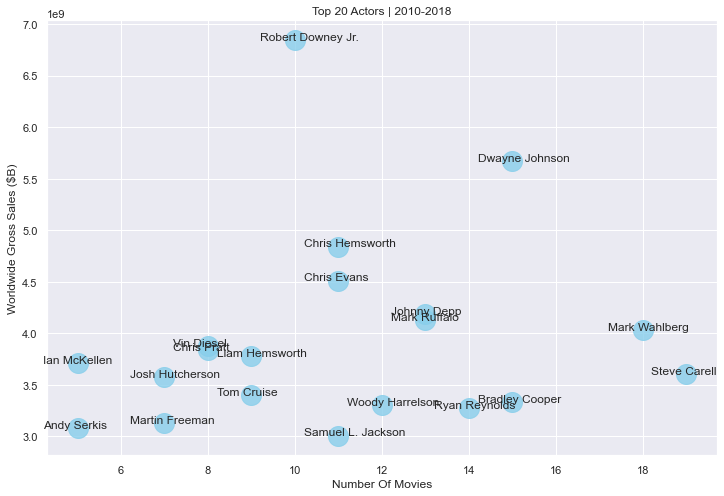

In [178]:
#f, ax = plt.subplots(figsize=(10, 10))
top20 = top[:20]
s = sns.regplot(data=top20, x="movie_count", y="ww_gross", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s': 400})
s.set(xlabel='Number Of Movies', ylabel='Worldwide Gross Sales ($B)', title='Top 20 Actors | 2010-2018') # set title and labels

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-.8, point['y']+.8, str(point['val']))

label_point(top20.movie_count, top20.ww_gross, top20.primary_name, plt.gca())

plt.show()

In [183]:
top20.describe()
top20.head()

,primary_name,movie_count,domestic_gross,foreign_gross,ww_gross,ww_gross_per_movie
3204,Robert Downey Jr.,10,2967300000,3876501370,6843801370,"684,380,137.00"
1015,Dwayne Johnson,15,2442400000,3232402173,5674802173,"378,320,144.87"
634,Chris Hemsworth,11,2164900000,2676201370,4841101370,"440,100,124.55"
631,Chris Evans,11,2049506100,2462601369,4512107469,"410,191,588.09"
1921,Johnny Depp,13,1160000000,3028000000,4188000000,"322,153,846.15"


In [199]:
top20_detail = prin[prin['primary_name'].isin(top20.primary_name)]
top20_detail.groupby('primary_name')['ww_gross'].apply(np.std) / top20_detail.groupby('primary_name')['ww_gross'].apply(np.mean)


primary_name
Andy Serkis         0.37
Bradley Cooper      1.06
Chris Evans         1.18
Chris Hemsworth     0.93
Chris Pratt         0.95
Dwayne Johnson      0.70
Ian McKellen        0.50
Johnny Depp         0.94
Josh Hutcherson     0.57
Liam Hemsworth      0.75
Mark Ruffalo        1.29
Mark Wahlberg       1.18
Martin Freeman      1.03
Robert Downey Jr.   0.67
Ryan Reynolds       1.15
Samuel L. Jackson   0.81
Steve Carell        1.60
Tom Cruise          0.69
Vin Diesel          0.60
Woody Harrelson     0.91
Name: ww_gross, dtype: float64

## Correlation

In [109]:
profits2 = movies[ (movies['tn_ind'] == 'both') & (movies['start_year'].between(2010,2019)) ]
profits3 = movies[ (movies['gross_ind'] == 'both') & (movies['start_year'].between(2010,2019)) ]

profit = profits2['worldwide_profit']
action = profits2['rating_sum']
result = profit.corr(action, method='pearson')
result

profits2.corr(method='pearson')


,start_year,runtime_minutes,avg_rating,num_votes,title_cnt,rating_sum,domestic_gross_x,foreign_gross,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,is_profitable,gross_per_rating
start_year,1.00,0.13,0.03,-0.10,nan,-0.09,0.10,0.10,0.06,0.08,0.08,0.08,0.03,0.00,0.04
runtime_minutes,0.13,1.00,0.41,0.43,nan,0.42,0.28,0.28,0.37,0.32,0.33,0.29,-0.03,0.20,-0.08
avg_rating,0.03,0.41,1.00,0.50,nan,0.51,0.29,0.25,0.23,0.33,0.31,0.31,0.02,0.31,0.01
num_votes,-0.10,0.43,0.50,1.00,nan,0.99,0.64,0.59,0.55,0.67,0.66,0.64,0.08,0.35,-0.02
title_cnt,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rating_sum,-0.09,0.42,0.51,0.99,nan,1.00,0.61,0.56,0.51,0.64,0.63,0.61,0.08,0.33,-0.02
domestic_gross_x,0.10,0.28,0.29,0.64,nan,0.61,1.00,0.80,0.69,1.00,0.94,0.93,0.07,0.31,-0.01
foreign_gross,0.10,0.28,0.25,0.59,nan,0.56,0.80,1.00,0.76,0.80,0.90,0.87,0.04,0.26,0.04
production_budget,0.06,0.37,0.23,0.55,nan,0.51,0.69,0.76,1.00,0.71,0.78,0.66,-0.03,0.29,0.05
domestic_gross_y,0.08,0.32,0.33,0.67,nan,0.64,1.00,0.80,0.71,1.00,0.95,0.94,0.11,0.40,-0.01


In [ ]:
profits.info()

# Appendix

In [ ]:
tip_rate = tips.eval("tip / total_bill").rename("tip_rate")

## Deprecated Code

In [23]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    movies['is_'+genre.lower()] = movies.apply(lambda x: int(genre in str(x.genres)), axis=1)

movies.head()

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,rating_sum,studio,domestic_gross_x,foreign_gross,gross_ind,title_cnt,production_budget,domestic_gross_y,worldwide_gross,worldwide_profit,profit_margin,is_profitable,tn_ind,gross_per_rating,is_action,is_adult,is_adventure,is_animation,is_biography,is_comedy,is_crime,is_documentary,is_drama,is_family,is_fantasy,is_game-show,is_history,is_horror,is_music,is_musical,is_mystery,is_news,is_reality-tv,is_romance,is_sci-fi,is_short,is_sport,is_talk-show,is_thriller,is_war,is_western
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.00,77,both,539.00,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,NaN,left_only,nan,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.20,43,both,309.60,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,NaN,left_only,nan,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.90,4517,both,"31,167.30",NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,NaN,left_only,nan,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.10,13,both,79.30,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,NaN,left_only,nan,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.50,119,both,773.50,NaN,<NA>,<NA>,left_only,1,nan,nan,nan,nan,nan,NaN,left_only,nan,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)